<a href="https://colab.research.google.com/github/albanda/CE888/blob/master/lab3/facebook_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import LabelEncoder

* We have loaded the necessary libraries above
* Now let's load the data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/ce888/master/lab3/dataset_Facebook.csv", delimiter=";")
df
#print("The dataset has %d columns and %d rows" % (df.shape[1], df.shape[0]))

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,85093,Photo,3,1,7,2,0.0,4684,7536,733,708,985,4750,2876,392,5,53.0,26.0,84
496,81370,Photo,2,1,5,8,0.0,3480,6229,537,508,687,3961,2104,301,0,53.0,22.0,75
497,81370,Photo,1,1,5,2,0.0,3778,7216,625,572,795,4742,2388,363,4,93.0,18.0,115
498,81370,Photo,3,1,4,11,0.0,4156,7564,626,574,832,4534,2452,370,7,91.0,38.0,136


In [3]:
print(df.columns)
features = ["Category", "Page total likes", "Type", "Post Month", "Post Hour",
            "Post Weekday", "Paid"]


print(df[features].head())

Index(['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid', 'Lifetime Post Total Reach',
       'Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share', 'Total Interactions'],
      dtype='object')
   Category  Page total likes    Type  ...  Post Hour  Post Weekday  Paid
0         2            139441   Photo  ...          3             4   0.0
1         2            139441  Status  ...         10             3   0.0
2         3            139441   Photo  ...          3             3   0.0
3         2            139441   Photo  ...         10             2   1.0
4         2            139441   Photo  ...          3             2   0.0

[

In [4]:
print("Number of rows before dropping NaNs: %d" % len(df))
df = df.dropna()
print("Number of rows after dropping NaNs: %d" % len(df))

Number of rows before dropping NaNs: 500
Number of rows after dropping NaNs: 495


In [5]:
outcomes=  ["Lifetime Post Total Reach",
            "Lifetime Post Total Impressions",
            "Lifetime Engaged Users",
            "Lifetime Post Consumers",
            "Lifetime Post Consumptions",
            "Lifetime Post Impressions by people who have liked your Page",
            "Lifetime Post reach by people who like your Page",
            "Lifetime People who have liked your Page and engaged with your post",
            "comment",
            "like",
            "share",
            "Total Interactions"]

df[outcomes].head()


,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [6]:
# convert a string variable to a categorical one
#types = list(set(df["Type"]))
#to_categorical = {types[i]:i for i in range(len(types))}
#df["Type"] = df["Type"].apply(lambda x: to_categorical[x])

df[["Type"]] = df[["Type"]].apply(LabelEncoder().fit_transform)

df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,1,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,2,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,1,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,1,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,1,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


Now let's prepare the data by cleaning it up and choosing the relevant column we would like to predict

In [7]:
#df = df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

outcomes_of_interest = ["Lifetime Post Consumers", "like"]

X_df = df[features].copy()
y_df = df[outcomes_of_interest].copy()

cat_features = ["Category", "Type", "Paid"]
#print(X_df.head())
#print(set(X_df["Category"]))
#print(pd.get_dummies(X_df, columns=["Category"]).head())

X_df = pd.get_dummies(X_df, columns=cat_features)

print(X_df.head()[["Category_1", "Category_2", "Category_3"]].to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Category\_1 &  Category\_2 &  Category\_3 \\
\midrule
0 &           0 &           1 &           0 \\
1 &           0 &           1 &           0 \\
2 &           0 &           0 &           1 \\
3 &           0 &           1 &           0 \\
4 &           0 &           1 &           0 \\
\bottomrule
\end{tabular}



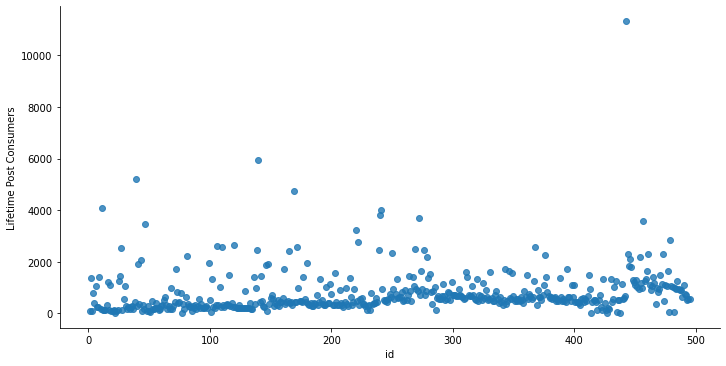

In [8]:
y_df['id'] = range(1, len(df) + 1)  # add a column
sns_plot = sns.lmplot(x="id", y="Lifetime Post Consumers", data=y_df, fit_reg=False, aspect=2)

# sns_plot.savefig("scaterplot_lpc.pdf", bbox_inches='tight')

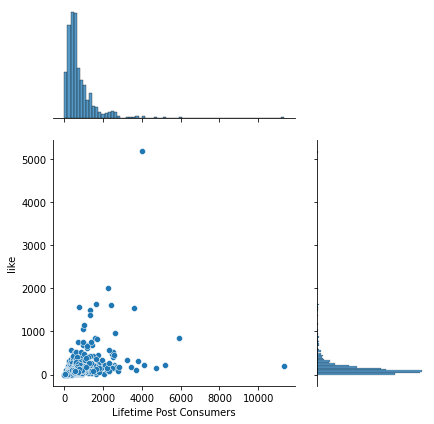

In [9]:
sns_plot = sns.jointplot(x="Lifetime Post Consumers", y="like", data=y_df, ratio = 2)
# sns_plot.savefig("joint_plot.pdf",bbox_inches='tight')

We can now train a classifier and then use the bootstrap to find an approximation of the bias and the variance

In [11]:
X = X_df.values
y = y_df.values.T[0]
y = (y - y.min())/(y.max() - y.min())  # standardise the target variable

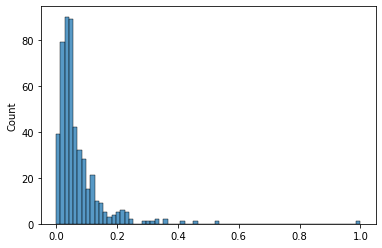

In [12]:
sns_plot = sns.histplot(y, kde=False)
# sns_plot.savefig("histogram_lpc.pdf",bbox_inches='tight')

In [13]:
clf = DecisionTreeRegressor()
clf.fit(X, y)
print("MSE of the model = %1.4g" % mse(y, clf.predict(X)))

MSE of the model = 1.508e-05


In [14]:
n_test = 100
n_repeat = 1000

estimator = DecisionTreeRegressor()
#estimator = RandomForestRegressor()

# Compute predictions
y_predicts = np.ones((n_repeat, len(X))) * np.nan

for i in range(n_repeat):
    sample  = np.random.choice(range(len(X)), replace=True, size=len(X))  # bootstrap!
    train_ids = sample[:-n_test]
    test_ids  = sample[-n_test:]
    test_ids = np.setdiff1d(test_ids, train_ids)  # only use those that weren't in the training set for testing
    if len(test_ids) == 0:
        continue
    X_train, y_train = X[train_ids], y[train_ids]
    X_test, y_test = X[test_ids], y[test_ids]
    
    estimator.fit(X_train, y_train)
    y_predict = estimator.predict(X_test)
    y_predicts[i, test_ids] = y_predict

In [15]:
y_bias = (y - np.nanmean(y_predicts, axis=0)) **2
y_error = np.nanmean((y - y_predicts) **2, axis=0)#.mean()
y_var = np.nanvar(y_predicts, axis=0, ddof = 1)

print(np.nanmean(y_bias) +  np.nanmean(y_var))

clf_type = "Decision tree"
print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          "+ {3:.4f} (var)".format(clf_type, np.nanmean(y_error), np.nanmean(y_bias), np.nanmean(y_var)))

print("{0}: {1:.4f} ((bias^2) + (var)) = {2:.4f} (bias^2) "
          "+ {3:.4f} (var)".format(clf_type, np.mean(y_bias) + np.mean(y_var), np.mean(y_bias), np.mean(y_var)))


0.010591841159100862
Decision tree: 0.0105 (error) = 0.0058 (bias^2) + 0.0048 (var)
Decision tree: 0.0106 ((bias^2) + (var)) = 0.0058 (bias^2) + 0.0048 (var)


In [16]:
#clf = RandomForestRegressor(n_estimators=1000,max_depth=2)
clf = BayesianRidge(normalize=True)
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(mse))

dummy_clf = DummyRegressor(strategy='mean')
dummy_scores = cross_val_score(dummy_clf, X, y, cv=10, scoring = make_scorer(mse))

print("MSE: %0.8f +/- %0.8f" % (scores.mean(), scores.std()))
print("Dummy MSE: %0.8f +/- %0.8f" % (dummy_scores.mean(), dummy_scores.std()))



MSE: 0.00479575 +/- 0.00511744
Dummy MSE: 0.00616020 +/- 0.00521769
